Decision Tree Demo
=======

By The End Of This Session You Should Be Able To:
----

- Fit a decision tree in scikit-learn
- Visualize the learned decision tree
- Tune regularization hyperparameters to increase generalization

In [1]:
reset -fs

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

import warnings
warnings.filterwarnings('ignore')

palette = "Dark2"
%matplotlib inline

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [24]:
iris = load_iris()
X = iris.data
y = iris.target

# # Take only 1 feature
# feature_index = 0 # {0, 1, 2, 3}
# X = X[:, feature_index].reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [25]:
from sklearn.tree import DecisionTreeClassifier

In [36]:
# max_leaf_nodes = 1   # Why is this an error? 
# max_leaf_nodes = 2   # Why is n_nodes = 3? Where is the extra node?
# max_leaf_nodes = 3 
max_leaf_nodes = X_train.shape[0] # What happens if I set the number to be equal samples?

dt = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes,
                            criterion='entropy',
                            random_state=42)
dt.fit(X_train, y_train);

n_nodes = dt.tree_.node_count
n_nodes

19

In [35]:
# Load pydotplus package
try:
    import pydotplus
except ImportError:
    import pip
    import sys
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'dit'])
    import pydotplus    

In [32]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz

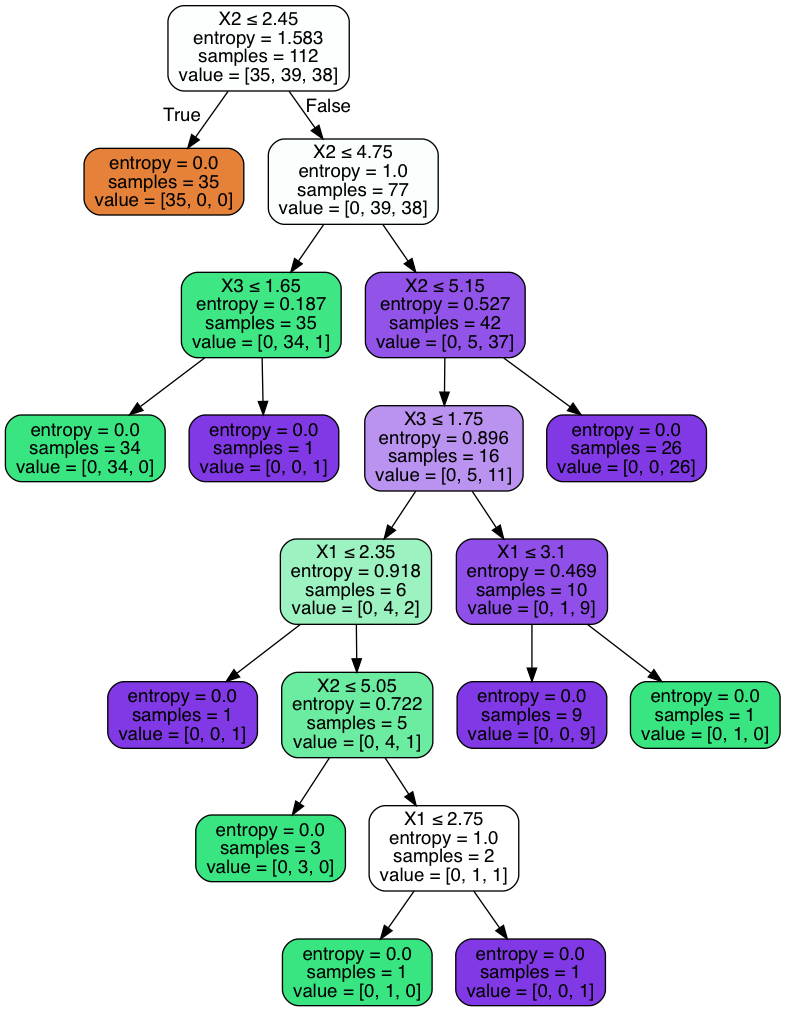

In [37]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Decision Stump
----

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cf/Decision_stump.svg/241px-Decision_stump.svg.png)

One-level decision tree.

A weak learner - "weak learners" or "base learners"

More on Decision Stumps later in the course

`tree_` Attribute
-----

The decision estimator has an attribute called tree_  which stores the entire tree structure and allows access to low level attributes. 

In [38]:
n_nodes = dt.tree_.node_count
children_left = dt.tree_.children_left # id of the left child of the node
children_right = dt.tree_.children_right # id of the right child of the node
feature = dt.tree_.feature # feature used for splitting the node
threshold = dt.tree_.threshold # threshold value at the node

In [39]:
# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0,   # Root node id
          -1)] # Parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True


In [12]:
# Let's walk the tree; Imperative style (because recrusion does not work well in Python)
print(f"The binary tree structure has {n_nodes} nodes.")
print()
print("This is binary tree structure:")
for i in range(n_nodes):
    if is_leaves[i]:
        print(f"Node #{i} is a leaf node.")
    else:
        print(f"Node #{i} test is split node: go to node {children_left[i]} if X[:, {feature[i]}] <= {threshold[i]:.3f} else to node {children_right[i]}.")
print()

The binary tree structure has 19 nodes.

This is binary tree structure:
Node #0 test is split node: go to node 1 if X[:, 2] <= 2.450 else to node 2.
Node #1 is a leaf node.
Node #2 test is split node: go to node 3 if X[:, 2] <= 4.750 else to node 4.
Node #3 test is split node: go to node 7 if X[:, 3] <= 1.650 else to node 8.
Node #4 test is split node: go to node 5 if X[:, 2] <= 5.150 else to node 6.
Node #5 test is split node: go to node 9 if X[:, 3] <= 1.750 else to node 10.
Node #6 is a leaf node.
Node #7 is a leaf node.
Node #8 is a leaf node.
Node #9 test is split node: go to node 13 if X[:, 1] <= 2.350 else to node 14.
Node #10 test is split node: go to node 11 if X[:, 1] <= 3.100 else to node 12.
Node #11 is a leaf node.
Node #12 is a leaf node.
Node #13 is a leaf node.
Node #14 test is split node: go to node 15 if X[:, 2] <= 5.050 else to node 16.
Node #15 is a leaf node.
Node #16 test is split node: go to node 17 if X[:, 1] <= 2.750 else to node 18.
Node #17 is a leaf node.
No

Let's retrieve the decision path of each sample. 
-----

In [40]:
sample_id = 15
# sample_id = np.random.choice(X_test.shape[0]) # Pick random row index


# A non-zero element of indicator matrix at the position (i, j) indicates that the sample i goes through the node j.
node_indicator = dt.decision_path(X_test) 

# Leave ids reached by each sample.
leave_id = dt.apply(X_test)

# Get the index that were used to predict a sample
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print(f'Rules used to predict sample #{sample_id}: ')
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(f"Split node #{node_id} : (X_test[{sample_id,}, {feature[node_id]}] (= {X_test[sample_id, feature[node_id]]}) {threshold_sign} {threshold[node_id]:.4f})")

Rules used to predict sample #15: 
Split node #0 : (X_test[(15,), 2] (= 4.7) > 2.4500)
Split node #2 : (X_test[(15,), 2] (= 4.7) <= 4.7500)
Split node #3 : (X_test[(15,), 3] (= 1.6) <= 1.6500)


Source: https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

Predict
-----

In [41]:
from sklearn.metrics import accuracy_score

In [42]:
predicted = dt.predict(X_test)
print(f"Accuracy: {accuracy_score(predicted, y_test):.3f}")

Accuracy: 0.974


-----
What about pruning in scikit-learn?
-----

[Not in default scikit-learn](https://github.com/scikit-learn/scikit-learn/issues/6557)

There is a package for that: [sklearn-post-prune-tree](https://github.com/shenwanxiang/sklearn-post-prune-tree)

How should we regularize instead?
-------

1. Set the minimum number of samples required at a leaf node or a split 
1. Setting the maximum depth of the tree 

[Let's check out the docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [43]:
kwargs_regularize = dict(criterion='entropy',
                         max_leaf_nodes=8,
                         max_depth=4, 
                         min_samples_split=10)
dt = DecisionTreeClassifier(**kwargs_regularize)
dt.fit(X_train, y_train)
predicted = dt.predict(X_test)
print(f"Accuracy: {accuracy_score(predicted, y_test):.3f}")

Accuracy: 0.974


<br>
<br> 
<br>

----

In [44]:
# scikit-learn defaults are very good
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
predicted = dt.predict(X_test)
print(f"Accuracy: {accuracy_score(predicted, y_test):.3f}")

Accuracy: 1.000


Summary
------

- scikit-learn decision tree API makes it easy to fit a decision tree
- Care must be taken with a few of the hyperparameters to avoid overfitting.

Challenge Question
--------

Given what you know about DT, what theoretical guarantee do they offer?

<br>
<details><summary>
Click here for the solution
</summary>
NONE - They work well in practice with extensive tuning
</details>

NOTE
-----

`min_impurity_split` should NOT be use

```	
Deprecated since version 0.19: min_impurity_split has been deprecated in favor of min_impurity_decrease in 0.19 and will be removed in 0.21. Use min_impurity_decrease instead.
```

<br>
<br> 
<br>

----

<br>
<br> 
<br>

----

Sources: 

- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
- https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176